## Load data and preprocessing

In [86]:
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense, Multiply, GlobalAveragePooling2D, Input, Concatenate, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [7]:
# verify if tensorflow is using GPU
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
train_dir = 'FER2013/train/'
test_dir = 'FER2013/test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


<Axes: >

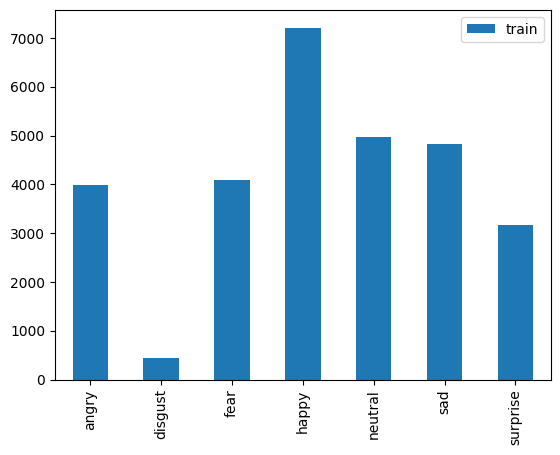

In [12]:
# plot train data count
train_count.transpose().plot(kind='bar')

<Axes: >

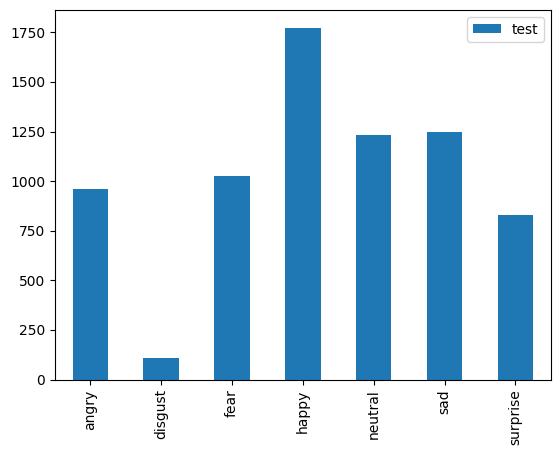

In [11]:
# plot test data count
test_count.transpose().plot(kind='bar')

In [28]:
labels = {
    "angry": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "neutral": 4,
    "sad": 5,
    "surprise": 6
}
num_classes = 7

In [16]:


def preprocess_image(image):
    # Normalize the pixel values to a range of 0-255
    cv2.normalize(image, image, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    # Apply histogram equalization to improve contrast
    image = cv2.equalizeHist(image)

    # Remove noisy images with low variance
    if np.var(image) < 10:
        return None

    return image

train_dir = os.path.abspath("FER2013/train")
train_X = []
train_y = []
# Loop through each image in the FER2013 dataset and preprocess it
for emotion in os.listdir(train_dir):
    if emotion == '.DS_Store':
        continue
    emotion_path = os.path.join(train_dir, emotion)
    for image_name in os.listdir(emotion_path):
        image_path = os.path.join(emotion_path, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        preprocessed_image = preprocess_image(image)

        # If the preprocessed image is not None, save it to the dataset
        if preprocessed_image is not None:
            train_X.append(preprocessed_image)
            train_y.append(labels[emotion])

In [44]:
train_X = np.array(train_X)
train_y = np.array(train_y)
print(train_X.shape, train_y.shape)

(28698, 48, 48) (28698,)


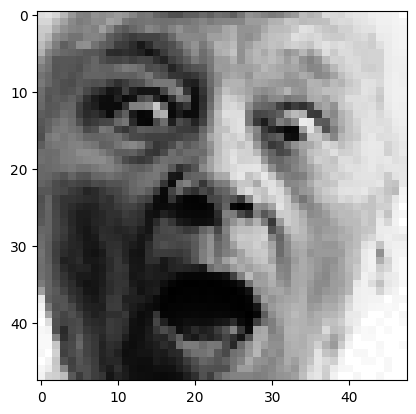

In [75]:
plt.imshow(train_X[-1], cmap='gray')
plt.show()

In [46]:
train_y[-1]

6

# Attention-based Emotion Region CNN (AER-CNN)

## Define Model

In [21]:
def AER_CNN():
    def attention_block(inputs, attention_channels):
        attention = Conv2D(attention_channels, kernel_size=(1, 1), activation='sigmoid')(inputs)
        return Multiply()([inputs, attention])

    input_shape = (48, 48, 1)
    num_classes = 7

    inputs = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=(3, 3), padding='same')(inputs)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = attention_block(x, 32)

    x = Conv2D(64, kernel_size=(3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = attention_block(x, 64)

    x = GlobalAveragePooling2D()(x)

    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, output)
    model.summary()
    return model

AER_CNN = AER_CNN()

2023-03-29 09:38:39.405393: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-29 09:38:39.405699: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-29 09:38:39.405893: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-29 09:38:40.117011: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-29 09:38:40.117419: I tensorflow/compile

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 32)   320         ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 48, 48, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 24, 24, 32)   0           ['activation[0][0]']             
                                                                                              

## Train

Epoch 1/30
718/718 [==============================] - 7s 8ms/step - loss: 1.2132 - accuracy: 0.5405 - val_loss: 1.4583 - val_accuracy: 0.4629
Epoch 2/30
718/718 [==============================] - 6s 9ms/step - loss: 1.2061 - accuracy: 0.5455 - val_loss: 1.4741 - val_accuracy: 0.4667
Epoch 3/30
718/718 [==============================] - 6s 9ms/step - loss: 1.2013 - accuracy: 0.5450 - val_loss: 1.4578 - val_accuracy: 0.4655
Epoch 4/30
718/718 [==============================] - 6s 9ms/step - loss: 1.2035 - accuracy: 0.5457 - val_loss: 1.4925 - val_accuracy: 0.4648
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 1.1945 - accuracy: 0.5455 - val_loss: 1.5041 - val_accuracy: 0.4467
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 1.1895 - accuracy: 0.5518 - val_loss: 1.4811 - val_accuracy: 0.4552
Epoch 7/30
718/718 [==============================] - 6s 8ms/step - loss: 1.1932 - accuracy: 0.5479 - val_loss: 1.4891 - val_accuracy: 0.4503
Epoch 

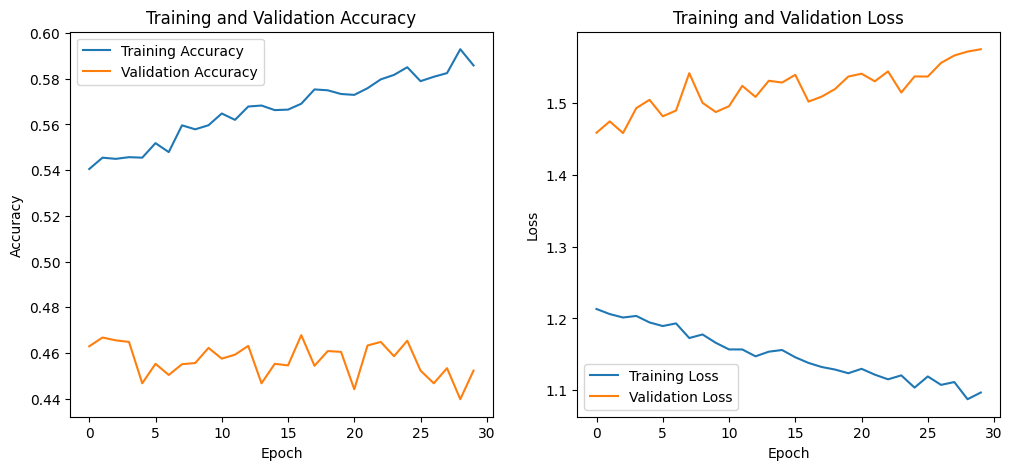

In [72]:
# Preprocess the data and split it into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

# Create the model
def train(model):

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32)

    # Plot the training and validation accuracy and loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.show()

train(AER_CNN)

In [74]:
AER_CNN.save("AER_CNN.h5")

In [58]:
# examples that load the saved model from file system
model2 = load_model('AER_CNN.h5')

# Load your test data
X_test, y_test = load_test_data()  # Implement this function to load your test data

# Preprocess the test data as needed

# Make predictions using the loaded model
predictions = model2.predict(X_test)

# Evaluate the loaded model on the test data (optional)
test_loss, test_accuracy = model2.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

# Multi-Scale Feature Fusion CNN (MSFF-CNN)

## Define Model

In [70]:
def MSFF_CNN():

    input_shape = (48, 48, 1)
    num_classes = 7

    inputs = layers.Input(shape=input_shape)
    # First branch
    x1 = Conv2D(32, (3, 3), padding='same')(inputs)
    x1 = Activation('relu')(x1)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)

    # Second branch
    x2 = Conv2D(64, (3, 3), padding='same')(inputs)
    x2 = Activation('relu')(x2)
    x2 = BatchNormalization()(x2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Conv2D(64, (3, 3), padding='same')(x2)
    x2 = Activation('relu')(x2)
    x2 = BatchNormalization()(x2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)

    # Third branch
    x3 = Conv2D(128, (3, 3), padding='same')(inputs)
    x3 = Activation('relu')(x3)
    x3 = BatchNormalization()(x3)
    x3 = MaxPooling2D(pool_size=(2, 2))(x3)
    x3 = Conv2D(128, (3, 3), padding='same')(x3)
    x3 = Activation('relu')(x3)
    x3 = BatchNormalization()(x3)
    x3 = MaxPooling2D(pool_size=(2, 2))(x3)
    x3 = Conv2D(128, (3, 3), padding='same')(x3)
    x3 = Activation('relu')(x3)
    x3 = BatchNormalization()(x3)
    x3 = MaxPooling2D(pool_size=(2, 2))(x3)

    # Resize feature maps to match the dimensions
    x2_upsampled = UpSampling2D(size=(2, 2))(x2)
    x3_upsampled = UpSampling2D(size=(4, 4))(x3)

    # Concatenate feature maps from the three branches
    x = layers.Concatenate()([x1, x2_upsampled, x3_upsampled])

    # Classifier
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, x)
    return model

MSFF_CNN = MSFF_CNN()

## Train

Epoch 1/30


2023-03-29 10:27:51.969811: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 52895232 exceeds 10% of free system memory.


718/718 [==============================] - 20s 20ms/step - loss: 1.6097 - accuracy: 0.3923 - val_loss: 1.3945 - val_accuracy: 0.4746
Epoch 2/30
718/718 [==============================] - 13s 19ms/step - loss: 1.3648 - accuracy: 0.4826 - val_loss: 1.4975 - val_accuracy: 0.4577
Epoch 3/30
718/718 [==============================] - 13s 19ms/step - loss: 1.1684 - accuracy: 0.5613 - val_loss: 1.5353 - val_accuracy: 0.4916
Epoch 4/30
718/718 [==============================] - 14s 19ms/step - loss: 0.9852 - accuracy: 0.6358 - val_loss: 3.8332 - val_accuracy: 0.3659
Epoch 5/30
718/718 [==============================] - 13s 19ms/step - loss: 0.8337 - accuracy: 0.6935 - val_loss: 1.4975 - val_accuracy: 0.5324
Epoch 6/30
718/718 [==============================] - 13s 19ms/step - loss: 0.6551 - accuracy: 0.7632 - val_loss: 2.6223 - val_accuracy: 0.5084
Epoch 7/30
718/718 [==============================] - 13s 19ms/step - loss: 0.5139 - accuracy: 0.8188 - val_loss: 2.8919 - val_accuracy: 0.3598
Epo

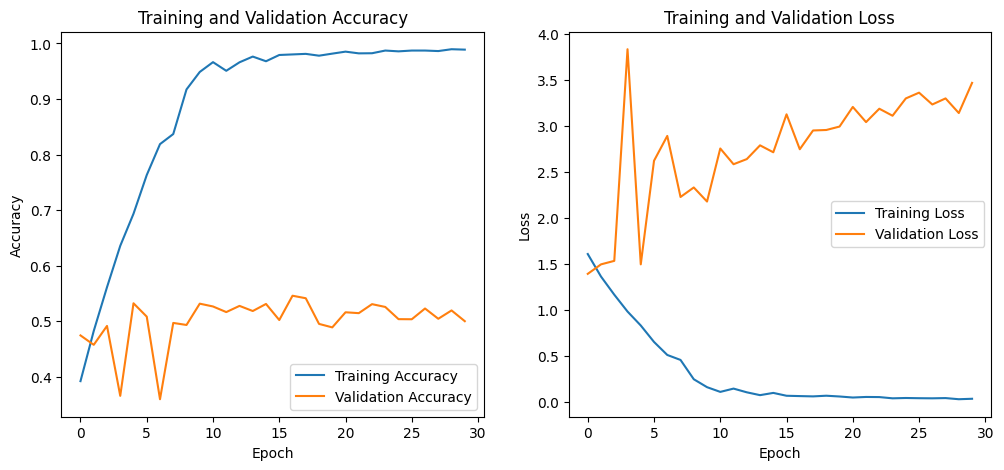

In [71]:
# Create the model
model = MSFF_CNN

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32)

# Plot the training and validation accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()

In [76]:
model.save("MSFF_CNN_original.h5")

## Investigation: very serious overfitting problem, trying to solve it...

In [81]:
# added dropout layers after every batch normalization layer with 30% dropout rate in every branch (x1, x2, x3)
def MSFF_CNN_dropout():

    input_shape = (48, 48, 1)
    num_classes = 7

    inputs = layers.Input(shape=input_shape)
    # First branch
    x1 = Conv2D(32, (3, 3), padding='same')(inputs)
    x1 = Activation('relu')(x1)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(0.3)(x1)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)

    # Second branch
    x2 = Conv2D(64, (3, 3), padding='same')(inputs)
    x2 = Activation('relu')(x2)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(0.3)(x2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Conv2D(64, (3, 3), padding='same')(x2)
    x2 = Activation('relu')(x2)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(0.3)(x2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)

    # Third branch
    x3 = Conv2D(128, (3, 3), padding='same')(inputs)
    x3 = Activation('relu')(x3)
    x3 = BatchNormalization()(x3)
    x3 = Dropout(0.3)(x3)
    x3 = MaxPooling2D(pool_size=(2, 2))(x3)
    x3 = Conv2D(128, (3, 3), padding='same')(x3)
    x3 = Activation('relu')(x3)
    x3 = BatchNormalization()(x3)
    x3 = Dropout(0.3)(x3)
    x3 = MaxPooling2D(pool_size=(2, 2))(x3)
    x3 = Conv2D(128, (3, 3), padding='same')(x3)
    x3 = Activation('relu')(x3)
    x3 = BatchNormalization()(x3)
    x3 = Dropout(0.3)(x3)
    x3 = MaxPooling2D(pool_size=(2, 2))(x3)

    # Resize feature maps to match the dimensions
    x2_upsampled = UpSampling2D(size=(2, 2))(x2)
    x3_upsampled = UpSampling2D(size=(4, 4))(x3)

    # Concatenate feature maps from the three branches
    x = layers.Concatenate()([x1, x2_upsampled, x3_upsampled])

    # Classifier
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, x)
    return model

MSFF_CNN_dropout = MSFF_CNN_dropout()

Epoch 1/30


2023-03-29 10:52:14.068780: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


718/718 [==============================] - 21s 25ms/step - loss: 1.5821 - accuracy: 0.4020 - val_loss: 10.7550 - val_accuracy: 0.4129
Epoch 2/30
718/718 [==============================] - 17s 24ms/step - loss: 1.3049 - accuracy: 0.5067 - val_loss: 1.4835 - val_accuracy: 0.4631
Epoch 3/30
718/718 [==============================] - 18s 25ms/step - loss: 1.1639 - accuracy: 0.5669 - val_loss: 1.4391 - val_accuracy: 0.4922
Epoch 4/30
718/718 [==============================] - 18s 24ms/step - loss: 1.0260 - accuracy: 0.6147 - val_loss: 1.7475 - val_accuracy: 0.4159
Epoch 5/30
718/718 [==============================] - 18s 25ms/step - loss: 0.9058 - accuracy: 0.6656 - val_loss: 1.7757 - val_accuracy: 0.4366
Epoch 6/30
718/718 [==============================] - 18s 25ms/step - loss: 0.7799 - accuracy: 0.7127 - val_loss: 2.2692 - val_accuracy: 0.5094
Epoch 7/30
718/718 [==============================] - 18s 24ms/step - loss: 0.6132 - accuracy: 0.7748 - val_loss: 3.4495 - val_accuracy: 0.4652
Ep

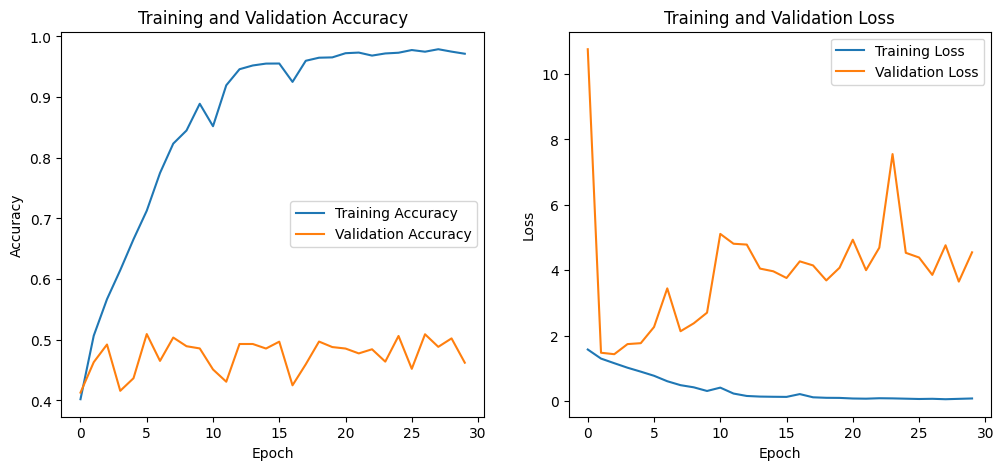

In [82]:
train(MSFF_CNN_dropout)

In [84]:
MSFF_CNN_dropout.save("MSFF_CNN_dropout.h5")

In [88]:
# the issue still exists, now we furthur resolve the overfitting problem by adding L2 regularization, but the result is still not ideal
def MSFF_CNN_dropout_l2reg():
    input_shape = (48, 48, 1)
    num_classes = 7

    inputs = layers.Input(shape=input_shape)
    l2_reg = 0.001

    # First branch with L2 regularization and dropout
    x1 = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(l2_reg))(inputs)
    x1 = Activation('relu')(x1)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(0.3)(x1)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)

    # Second branch with L2 regularization and dropout
    x2 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(l2_reg))(inputs)
    x2 = Activation('relu')(x2)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(0.3)(x2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(l2_reg))(x2)
    x2 = Activation('relu')(x2)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(0.3)(x2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)

    # Third branch with L2 regularization and dropout
    x3 = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(l2_reg))(inputs)
    x3 = Activation('relu')(x3)
    x3 = BatchNormalization()(x3)
    x3 = Dropout(0.3)(x3)
    x3 = MaxPooling2D(pool_size=(2, 2))(x3)
    x3 = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(l2_reg))(x3)
    x3 = Activation('relu')(x3)
    x3 = BatchNormalization()(x3)
    x3 = Dropout(0.3)(x3)
    x3 = MaxPooling2D(pool_size=(2, 2))(x3)
    x3 = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(l2_reg))(x3)
    x3 = Activation('relu')(x3)
    x3 = BatchNormalization()(x3)
    x3 = Dropout(0.3)(x3)
    x3 = MaxPooling2D(pool_size=(2, 2))(x3)
    
    # Resize feature maps to match the dimensions
    x2_upsampled = UpSampling2D(size=(2, 2))(x2)
    x3_upsampled = UpSampling2D(size=(4, 4))(x3)
    
    # Concatenate feature maps from the three branches
    x = layers.Concatenate()([x1, x2_upsampled, x3_upsampled])

    # Classifier
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, x)
    return model

MSFF_CNN_dropout_l2reg = MSFF_CNN_dropout_l2reg()

Epoch 1/30


2023-03-29 11:03:09.209291: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/dropout_15/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


718/718 [==============================] - 21s 26ms/step - loss: 1.8605 - accuracy: 0.4016 - val_loss: 2.9409 - val_accuracy: 0.4052
Epoch 2/30
718/718 [==============================] - 18s 25ms/step - loss: 1.5563 - accuracy: 0.4888 - val_loss: 1.9251 - val_accuracy: 0.3852
Epoch 3/30
718/718 [==============================] - 18s 25ms/step - loss: 1.4326 - accuracy: 0.5372 - val_loss: 11.2874 - val_accuracy: 0.4017
Epoch 4/30
718/718 [==============================] - 18s 25ms/step - loss: 1.2771 - accuracy: 0.5826 - val_loss: 3.7857 - val_accuracy: 0.4389
Epoch 5/30
718/718 [==============================] - 18s 25ms/step - loss: 1.2523 - accuracy: 0.6078 - val_loss: 2.6848 - val_accuracy: 0.4138
Epoch 6/30
718/718 [==============================] - 18s 25ms/step - loss: 1.0658 - accuracy: 0.6670 - val_loss: 7.8687 - val_accuracy: 0.4105
Epoch 7/30
718/718 [==============================] - 18s 25ms/step - loss: 0.9284 - accuracy: 0.7183 - val_loss: 8.0360 - val_accuracy: 0.4775
Ep

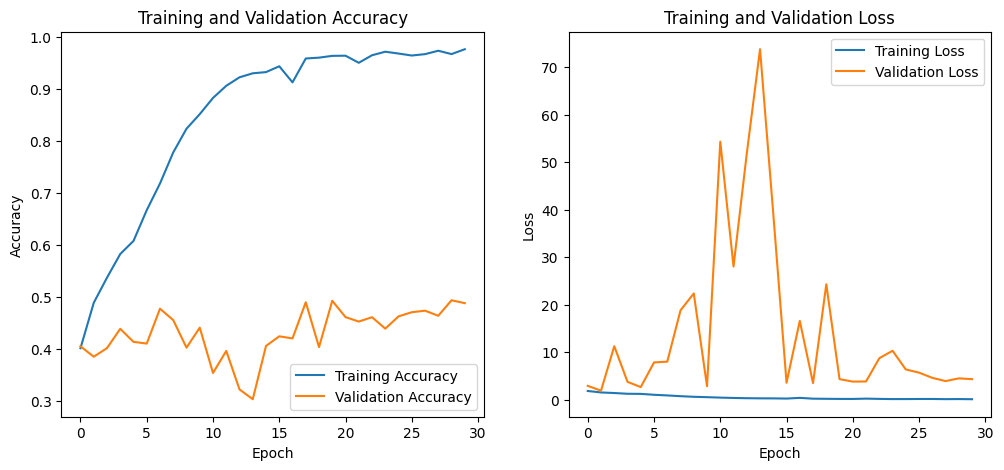

In [89]:
train(MSFF_CNN_dropout_l2reg)

In [90]:
MSFF_CNN_dropout_l2reg.save("MSFF_CNN_dropout_l2reg.h5")

## Model Explanation

1. Attention-based Emotion Region CNN (AER-CNN):
AER-CNN focuses on emotion-relevant facial regions (e.g., eyes, mouth) using an attention mechanism.

Implement an attention mechanism (e.g., self-attention or spatial attention) to weigh the importance of different facial regions.
Apply this attention mechanism to the feature maps at different layers of the CNN.
Fuse the attention-weighted feature maps before passing them through the fully connected layers and the softmax layer for classification.
The novelty in this architecture lies in the attention mechanism's ability to focus on emotion-relevant regions, which may help in learning more discriminative features for FER.

2. Multi-Scale Feature Fusion CNN (MSFF-CNN):
The MSFF-CNN model can fuse features from different scales in a hierarchical fashion. This architecture addresses the issue that facial expressions can appear at various scales due to different distances from the camera, varying face sizes, and diverse expressions.

Start with a typical CNN architecture consisting of convolutional, activation, and pooling layers.
After each pooling layer, add a parallel branch that extracts features at different scales.
Fuse the outputs of these branches using concatenation or summation.
Follow this with fully connected layers and a softmax layer for classification.
The novelty in this architecture lies in the fusion of multi-scale features, allowing the model to learn features from different scales in a single pass.


## Conclusion
Multi-Scale Feature Fusion CNN (MSFF-CNN) may noy be an ideal architecture to this problem as it is easily overfitted in a few epochs.
However, the problem may not caused by architecture, it could be caused by FER2013 dataset as this dataset is not large, furthur improvement can be done on fine tuning the hyperparameters and input augmentation.

So as a comparison, Attention-based Emotion Region CNN (AER-CNN) is slightly more robust than the other one.

Both model has a peak performance of 0.5 accuracy on validation set.